# Ejercicio 1

### Importar librerías

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import tensorflow as tf
import tensorflow_datasets as tfds
import warnings
import IPython
import os
import pandas as pd
import librosa
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")
seed = 100
tf.random.set_seed(seed)
np.random.seed(seed)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('DEBUG')

## Creación de dataset
Vamos a generar un dataframe utilizando pandas para tener ordenados nuestros archivos de sonido con sus respectivas clases

In [ ]:
archivos = os.listdir("./recordings")
data = []
for archivo in archivos:
    if not archivo.endswith(".wav"): continue
    clase = int(archivo[0])
    data.append({
        "nombre": archivo,
        "label": clase,
    })
descripcion = pd.DataFrame(data)
descripcion.head()

,nombre,label
0,5_lucas_40.wav,5
1,7_theo_14.wav,7
2,2_lucas_33.wav,2
3,5_yweweler_23.wav,5
4,7_lucas_6.wav,7


## Exploración de los audios
En esta parte nos proponemos ver las ondas de sonido junto con su espectograma.
Para ello, utilizaremos librosa(https://librosa.org/doc/latest/index.html): una librería de python que facilita el análisis de audio

**Conceptos importantes**
- **Sampling Rate (Frecuencia de muestreo)**: Cantidad de muestras de audio que se toman en un segundo
- **Espectograma**: Se basa en la aplicación de la transformada de Fourier en cada instante de tiempo del audio
- **Espectograma de Mel**: Mejora el espectograma original al simular cómo percibe el oído humano las diferencias de tono. No sigue una escala de frecuencia lineal

<Figure size 3000x300 with 0 Axes>

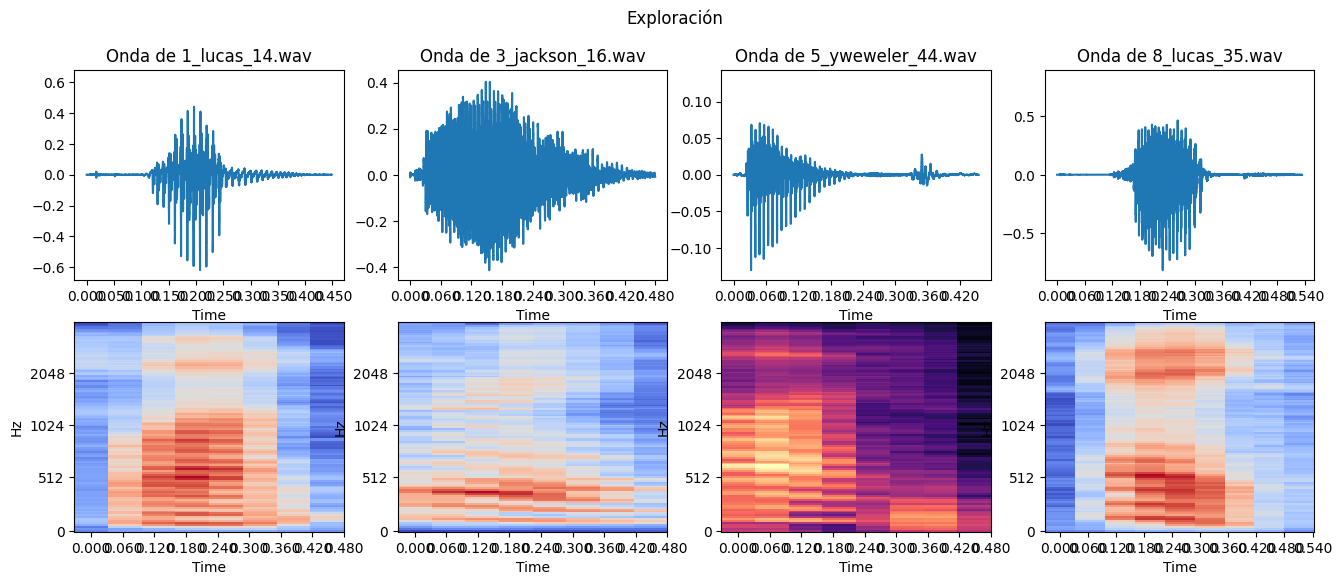

In [ ]:
tags_visualizar = [1, 3, 5, 8]
plt.figure(figsize=(30, 3))
fig, axs = plt.subplots(nrows=2, ncols=(len(tags_visualizar)), figsize=(16, 6))
axs = axs.flatten()
fig.suptitle("Exploración")
for i, digito in enumerate(tags_visualizar):
    #Primero tomamos un archivo aleatorio que coincida con "digito"
    archivo_random = np.random.choice(descripcion[descripcion["label"] == digito]["nombre"])
    #Cargamos el archivo y dejamos que librosa detecte el sampling rate (sr)
    audio, sr = librosa.load(os.path.join("recordings", archivo_random), sr=None)
    #Utillizando el módulo "display" mostramos la onda de sonido
    librosa.display.waveshow(y=audio, sr=sr, x_axis="time", ax=axs[i])
    axs[i].set(title=f"Onda de {archivo_random}")
    #Se calcula el espectograma del audio y se converte a decibelios (escala logarítmica)
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr))
    librosa.display.specshow(data=mels_db, sr=sr, x_axis="time", y_axis="mel", ax=axs[i + len(tags_visualizar)])

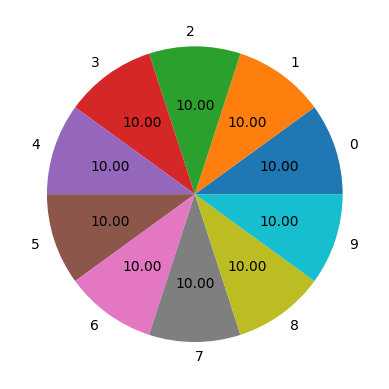

In [ ]:
plt.pie(descripcion["label"].value_counts() / len(descripcion["label"]), labels=np.unique(descripcion["label"]), autopct=f"%.2f")
plt.show()

Todas las clases están distribuidas equitativamente.

No vamos a tener problemas de sesgo en el modelo.

Vamos a poder utilizar la métrica "accuracy"

## Creación del modelo convolucional
Lo que debemos hacer es iterar sobre cada archivo y trabajarlo.

Debemos lograr que todos los audios tengan la misma shape pero tenemos un problema, ya que los audios tienen distintas longitudes (duración) así que vamos a convertirlos a un segundo de longitud. Debemos hacer esto sin alterar su tono.

Para ello usamos la función **time_stretch**. Esta función espera dos parámetros:
- **y**: Audio a transformar
- **rate**: Factor de ajuste. Si *rate > 1*, entonces la señan se acelera (audio más corto), si *rate < 1*, la señal se ralentiza (audio más lento), si *rate = 1* la señal permanece igual.
Para lograr que time_stretch devuelva un audio con duración de 1 segundo, debemos hacer que "rate" sea la duración en segundos del audio

In [ ]:
feature = []
label = []
for file in os.listdir("./recordings/"):
    if not file.endswith(".wav"):
        continue
    audio_path = os.path.join("recordings", file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    #Transformar audio a un segundo. len(audio) / sr da la duración en segundos del audio
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio) / sr)
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    #Se aplica un reshape para que todos los audios tengan la misma forma. 128 * 16 = 2048
    feature.append(mels_db.reshape((128, 16, 1)))
    label.append(file[0])
features = np.array(feature)
labels = np.array(label)

In [ ]:
model = models.Sequential([
    layers.InputLayer(input_shape=features[0].shape),
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3, activation="relu"),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(np.unique(labels).shape[0], activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                        

2024-06-23 13:35:25.334117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-23 13:35:25.334398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-06-23 13:35:25.334478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-06-23 13:35:25.334550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcu

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

In [ ]:
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 50
#Codificar labels para predicción
encoded_labels = tf.one_hot(indices=labels, depth=10)
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)
history = model.fit(
    x=X_train,
    y=y_train,
    validation_split=TEST_SIZE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)]
)

Epoch 1/50
23/23 [==============================] - 2s 64ms/step - loss: 4.6326 - accuracy: 0.2156 - val_loss: 1.3935 - val_accuracy: 0.6095
Epoch 2/50
23/23 [==============================] - 1s 56ms/step - loss: 1.0773 - accuracy: 0.6265 - val_loss: 0.4203 - val_accuracy: 0.8937
Epoch 3/50
23/23 [==============================] - 1s 56ms/step - loss: 0.5449 - accuracy: 0.8184 - val_loss: 0.2518 - val_accuracy: 0.9333
Epoch 4/50
23/23 [==============================] - 1s 56ms/step - loss: 0.3523 - accuracy: 0.8871 - val_loss: 0.1610 - val_accuracy: 0.9619
Epoch 5/50
23/23 [==============================] - 1s 56ms/step - loss: 0.2953 - accuracy: 0.9082 - val_loss: 0.1492 - val_accuracy: 0.9619
Epoch 6/50
23/23 [==============================] - 1s 56ms/step - loss: 0.2083 - accuracy: 0.9272 - val_loss: 0.1267 - val_accuracy: 0.9651
Epoch 7/50
23/23 [==============================] - 1s 55ms/step - loss: 0.1749 - accuracy: 0.9381 - val_loss: 0.1195 - val_accuracy: 0.9619
Epoch 8/50
23

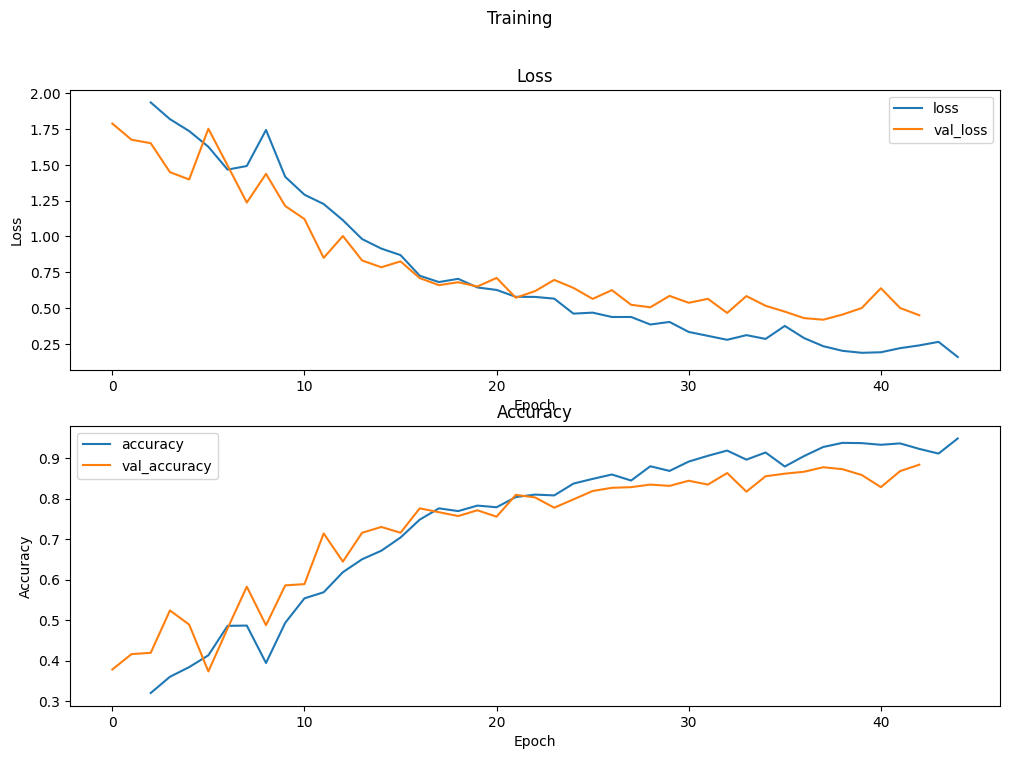

In [ ]:
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle("Training")
axs[0].plot(history.epoch[2:], history.history["loss"][2:], history.history["val_loss"][2:])
axs[0].set(title="Loss", xlabel="Epoch", ylabel="Loss")
axs[0].legend(["loss", "val_loss"])
axs[1].plot(history.epoch[2:], history.history["accuracy"][2:], history.history["val_accuracy"][2:])
axs[1].set(title="Accuracy", xlabel="Epoch", ylabel="Accuracy")
axs[1].legend(["accuracy", "val_accuracy"])
plt.show()

In [ ]:
print("Accuracy", history.history["accuracy"][-1])
print("Validation Accuracy", history.history["val_accuracy"][-1])

Accuracy 0.9809523820877075
Validation Accuracy 0.9730158448219299


No hay overfitting

### Matríz de confusión

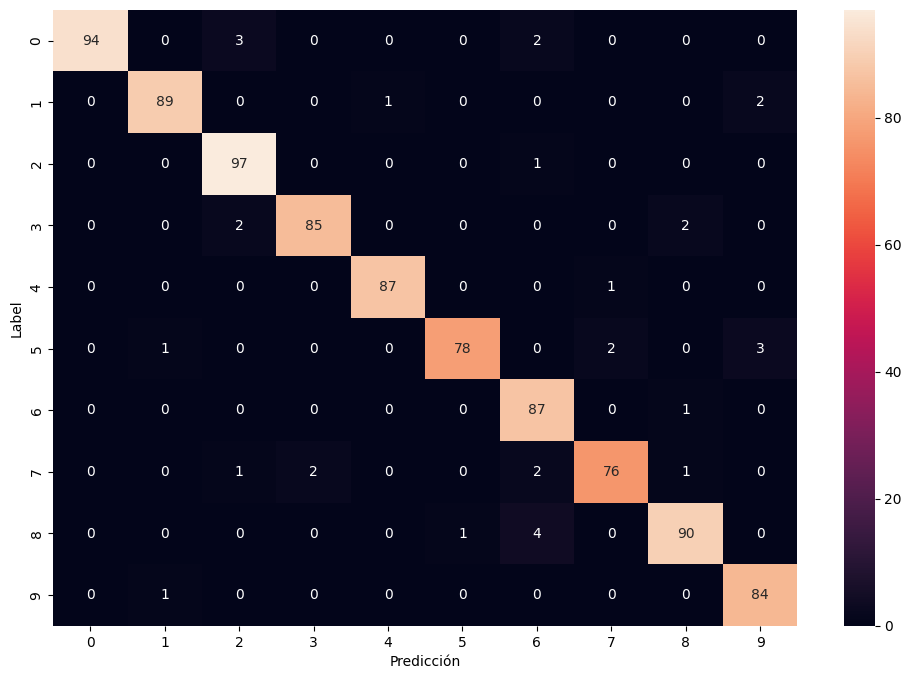

In [ ]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sbn.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt="g")
plt.xlabel("Predicción")
plt.ylabel("Label")
plt.show()

### Reporte de clasificación

In [ ]:
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89        80
           1       0.93      0.77      0.84        96
           2       0.88      0.87      0.87        90
           3       0.91      0.85      0.88        98
           4       0.94      0.97      0.96        88
           5       0.79      0.85      0.82       100
           6       0.91      0.68      0.78       105
           7       0.76      0.82      0.79        74
           8       0.72      0.96      0.82        80
           9       0.75      0.83      0.79        89

    accuracy                           0.84       900
   macro avg       0.85      0.85      0.84       900
weighted avg       0.85      0.84      0.84       900



## Creación de modelo recurrente

In [ ]:
modelRec = models.Sequential([
    layers.InputLayer(input_shape=(features[0].shape[0], features[0].shape[1])),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.25),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(256, return_sequences=False),
    layers.Dropout(0.25),
    layers.Dense(np.unique(labels).shape[0], activation="softmax")
])
modelRec.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 128, 64)           20736     
                                                                 
 dropout_41 (Dropout)        (None, 128, 64)           0         
                                                                 
 lstm_39 (LSTM)              (None, 128, 128)          98816     
                                                                 
 dropout_42 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_40 (LSTM)              (None, 256)               394240    
                                                                 
 dropout_43 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 10)              

In [ ]:
modelRec.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)
history = modelRec.fit(
    x=X_train,
    y=y_train,
    validation_split=TEST_SIZE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)]
)

Epoch 1/50
23/23 [==============================] - 8s 253ms/step - loss: 2.1838 - accuracy: 0.2014 - val_loss: 2.0151 - val_accuracy: 0.2571
Epoch 2/50
23/23 [==============================] - 5s 225ms/step - loss: 1.8756 - accuracy: 0.3340 - val_loss: 1.6941 - val_accuracy: 0.4317
Epoch 3/50
23/23 [==============================] - 5s 226ms/step - loss: 1.5670 - accuracy: 0.4673 - val_loss: 1.5838 - val_accuracy: 0.4349
Epoch 4/50
23/23 [==============================] - 5s 236ms/step - loss: 1.3191 - accuracy: 0.5517 - val_loss: 1.2747 - val_accuracy: 0.5762
Epoch 5/50
23/23 [==============================] - 6s 246ms/step - loss: 1.1135 - accuracy: 0.6156 - val_loss: 1.0112 - val_accuracy: 0.6667
Epoch 6/50
23/23 [==============================] - 6s 247ms/step - loss: 0.9056 - accuracy: 0.6816 - val_loss: 0.9663 - val_accuracy: 0.6905
Epoch 7/50
23/23 [==============================] - 6s 247ms/step - loss: 0.8969 - accuracy: 0.6980 - val_loss: 0.8536 - val_accuracy: 0.7063
Epoch 

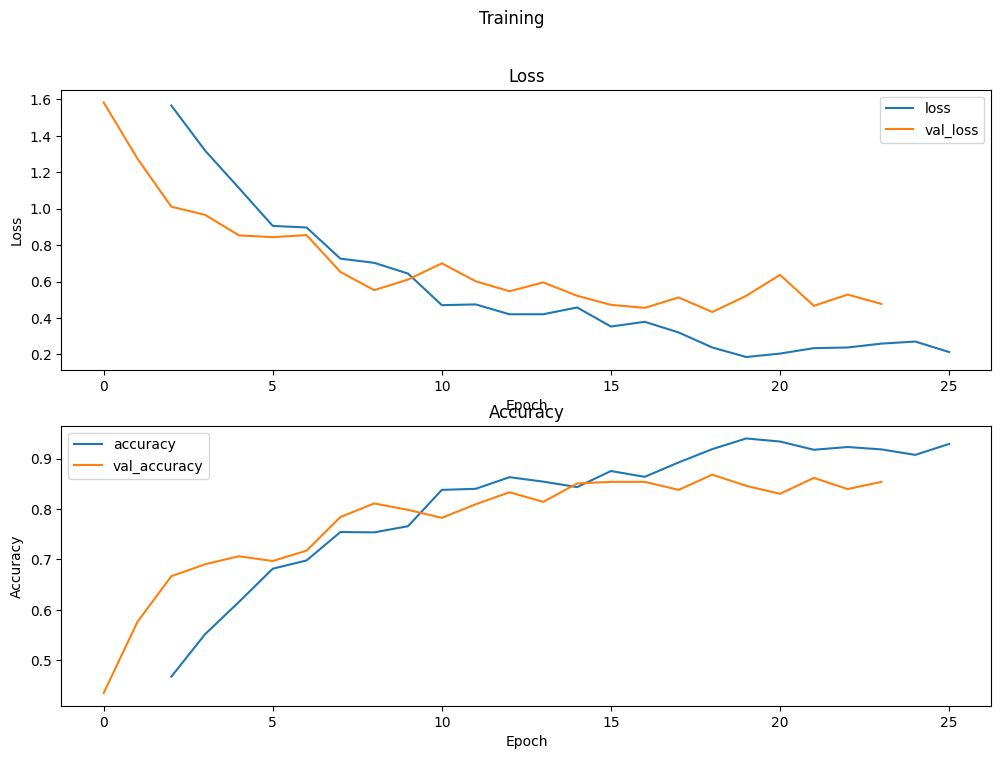

In [ ]:
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle("Training")
axs[0].plot(history.epoch[2:], history.history["loss"][2:], history.history["val_loss"][2:])
axs[0].set(title="Loss", xlabel="Epoch", ylabel="Loss")
axs[0].legend(["loss", "val_loss"])
axs[1].plot(history.epoch[2:], history.history["accuracy"][2:], history.history["val_accuracy"][2:])
axs[1].set(title="Accuracy", xlabel="Epoch", ylabel="Accuracy")
axs[1].legend(["accuracy", "val_accuracy"])
plt.show()

Se observa en el gráfico que en un principio nuestro modelo contaba con overfitting, pero luego de las iteraciones eso fue mejorando hasta lograr un modelo bien entrenado

In [ ]:
print("Accuracy", history.history["accuracy"][-1])
print("Validation Accuracy", history.history["val_accuracy"][-1])

Accuracy 0.9292517304420471
Validation Accuracy 0.8539682626724243


### Matríz de confusión

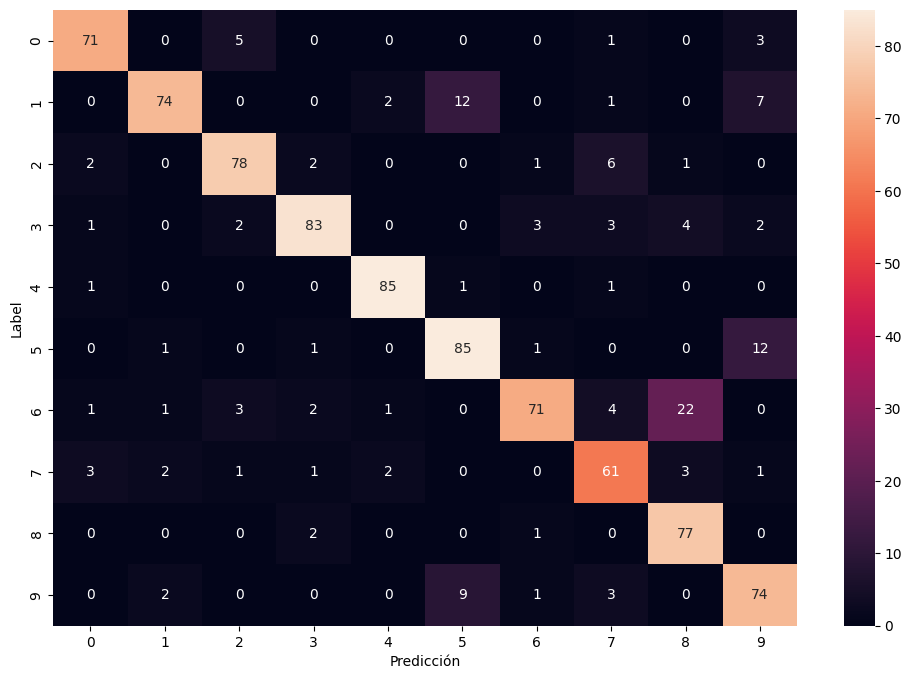

In [ ]:
y_predicted = np.argmax(modelRec.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sbn.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt="g")
plt.xlabel("Predicción")
plt.ylabel("Label")
plt.show()

### Reporte de clasificación

In [ ]:
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89        80
           1       0.93      0.77      0.84        96
           2       0.88      0.87      0.87        90
           3       0.91      0.85      0.88        98
           4       0.94      0.97      0.96        88
           5       0.79      0.85      0.82       100
           6       0.91      0.68      0.78       105
           7       0.76      0.82      0.79        74
           8       0.72      0.96      0.82        80
           9       0.75      0.83      0.79        89

    accuracy                           0.84       900
   macro avg       0.85      0.85      0.84       900
weighted avg       0.85      0.84      0.84       900



## Conclusión
Observando las métricas de ambos modelos, podemos llegar a la conclusión de que ambos dieron buenos resultados, sin embargo, se requirió menos iteraciones y se ubtuvo mejores resultados utilizando el modelo convolucional además que su entrenamiento resultó ser más rápido en cada epoch

# Ejercicio 2

## Importar librerías

In [29]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import os

from collections import Counter

## Configuraciones iniciales

In [30]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Creación del dataset
Obtenemos el [dataset de TensorFlow](https://www.google.com/url?q=https://www.tensorflow.org/datasets/catalog/ag_news_subset&sa=D&source=editors&ust=1720622084514811&usg=AOvVaw3GdvD3hxARQs24i0mNilom), la separamos en datos de entrenamiento y test. Además creamos el corpus de la data obtenida

In [31]:
# Se carga el dataset AG News Subset que se obtiene de TensorFlow y también lo separamos en datos de entrenamiento y testeo
dataset, info = tfds.load('ag_news_subset', with_info=True, as_supervised=True)

train_data = dataset['train']
test_data = dataset['test']

# Función para pre-procesar el texto extraído
def preprocess_text(text):
    text = text.numpy().decode('utf-8')
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', '')
    return text

# Acá creamos el corpus de toda la data del dataset
corpus = ""
for text, _ in train_data:
    corpus += preprocess_text(text) + " "

## Exploración del dataset

In [32]:
print(f"Total de artículos en el conjunto de entrenamiento: {len(list(train_data))}")
print(f"Total de artículos en el conjunto de prueba: {len(list(test_data))}")
print(f"Longitud del corpus: {len(corpus)} caracteres")
print(f"Número de caracteres únicos: {len(set(corpus))}")

Total de artículos en el conjunto de entrenamiento: 120000
Total de artículos en el conjunto de prueba: 7600
Longitud del corpus: 23328242 caracteres
Número de caracteres únicos: 56


Vemos que tenemos un dataset extenso en contenido por lo que no tendremos problemas para poder entrenar nuestros modelos, además de que la cantidad de caracteres únicos es demasiado útil para nuestro modelo de caracteres que entrenaremos a continuación

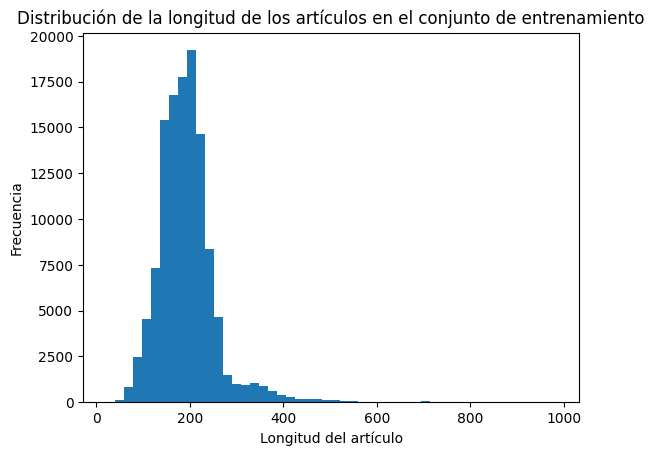

In [33]:
article_lengths = [len(preprocess_text(text)) for text, _ in train_data]
plt.hist(article_lengths, bins=50)
plt.xlabel('Longitud del artículo')
plt.ylabel('Frecuencia')
plt.title('Distribución de la longitud de los artículos en el conjunto de entrenamiento')
plt.show()

El dataset tiende a rondar los 200 caracteres por artículo por lo que esto será más que suficiente para poder establecer una meta para lograr noticias falsas

In [34]:
word_list = corpus.split()
word_count = len(word_list)
unique_words = set(word_list)
unique_word_count = len(unique_words)
print(f"Número total de palabras: {word_count}")
print(f"Número de palabras únicas: {unique_word_count}")

Número total de palabras: 3727523
Número de palabras únicas: 140664


Como se observa, la cantidad de palabras únicas que encontramos es gigante, lo que puede resultar en un modelo muy pesado y lento para entrenar.

In [35]:
word_freq = Counter(word_list)
common_words = word_freq.most_common(20)
print("Palabras más comunes:")
for word, freq in common_words:
    print(f"{word}: {freq}")

Palabras más comunes:
the: 196913
a: 102489
to: 95156
of: 88809
in: 77719
and: 65619
on: 46859
-: 38028
for: 37684
that: 27171
#39;s: 25000
with: 22526
as: 21686
its: 21065
at: 20660
is: 19716
by: 18550
has: 18188
it: 17438
new: 17072


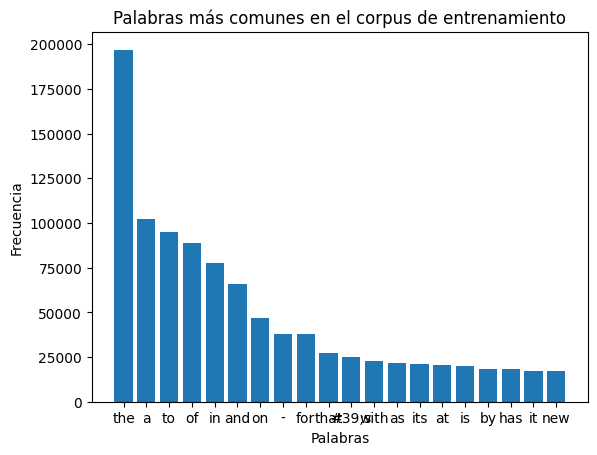

In [36]:
words, freqs = zip(*common_words)
plt.bar(words, freqs)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más comunes en el corpus de entrenamiento')
plt.show()

Se observa que dentro de las palabras más utilizadas encontramos guiones o caracteres especiales que a futuro se quitarán para no entorpecer la generación de texto.

## Modelos

### Modelo de caracteres

#### Preparación del dataset para este modelo

In [37]:
# Tokenizamos al nivel de caracteres
chars = sorted(set(corpus))
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = np.array(chars)

text_as_int = np.array([char_to_idx[c] for c in corpus])

# Se crean las secuencias de entranemiento para entrenar el modelo
seq_length = 100
examples_per_epoch = len(corpus) // seq_length
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

# Creamos los lotes de datos
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

#### Definición del modelo

En este apartado definimos una condición (para no perder el tiempo) si el modelo ya fue entrenado simplemente utilizamos los pesos del modelo ya entrenado, en caso contrario procedemos a entrenarlo.

In [38]:
vocab_size = len(chars)
embedding_dim = 256
rnn_units = 1024

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

if os.path.exists('char_model.h5'):
    model = build_model(vocab_size=len(chars), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=1)
    model.load_weights('char_model.h5')
    model.build(tf.TensorShape([1, None]))
else:
    model = build_model(vocab_size=len(chars), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE)

    def loss(labels, logits):
        return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

    model.compile(optimizer='adam', loss=loss)
    model.build(tf.TensorShape([1, None]))

#### Entrenamiento del modelo

Como en la celda anterior, si el modelo ya fue entrenado no lo volvemos a entrenar.

In [39]:
if os.path.exists('char_model.h5'):
    print("Modelo ya entrenado")
    pass
else:
    EPOCHS = 10
    history = model.fit(dataset, epochs=EPOCHS)

    model.save('char_model.h5')

Modelo ya entrenado


#### Generación de texto

A continuación evaluaremos el modelo en base a su generación texto a texto

In [40]:
def generate_text(model, start_string, num_generate=1000):
    start_string = start_string.lower()

    for char in start_string:
        if char not in char_to_idx:
            raise ValueError(f"Carácter '{char}' no encontrado en el vocabulario.")

    input_eval = [char_to_idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx_to_char[predicted_id])

    return start_string + ''.join(text_generated)

first_new = "The economy is"
second_new = "The president is"
third_new = "The world is"

print("Primera generación:", generate_text(model, start_string=first_new))
print("Segunda generación:", generate_text(model, start_string=second_new))
print("Tercera generación:", generate_text(model, start_string=third_new))

Primera generación: the economy is strong. ap - a companied by news - research leader healtharesday's and new philippine public employees at old time last week. steve schreel slaughters will held on their argumenthant the go-ahead: her hospital friday, but it might not be had her awaiting en and all hurtles starting jackson in the first half would be far bevo dorse war crimes related\to your nationalist elections campaign, but an improvement in the war on terver abou7 when poorly union e wide raven stadium of new york yankees 1-2 in game 1 of this weekend. us auction of compuware memory, although the stars. becoming the resignation of a company with the \$41 billion threat of sa as data from the u.s. men's closing services in august, which professes with its heating oil tave advertising results from its rian area in overtime and away more possible changes in desengation. florida, which appeared on its \$50 billion. sahorey (reuters) - ghtiational in iraq during sex, beneficiaries have 

### Modelo de palabras

#### Preparación del dataset para este modelo

In [41]:
# Se crea una función para pre-procesar el texto en palabras
def preprocess_text_word(text):
    text = text.numpy().decode('utf-8')
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Eliminamos la puntuación
    text = text.replace('\n', ' ').replace('\r', '')
    return text

# A su vez también creamos un nuevo Corpus de palabras
corpus_word = ""
for text, _ in train_data:
    corpus_word += preprocess_text_word(text) + " "

# Tokenizamos a nivel de palabras
words = corpus_word.split()
vocab = sorted(set(words))
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = np.array(vocab)

text_as_int_word = np.array([word_to_idx[word] for word in words])

# Creamos las secuencias para el entrenamiento
seq_length_word = 20
examples_per_epoch_word = len(words) // seq_length_word
word_dataset = tf.data.Dataset.from_tensor_slices(text_as_int_word)

sequences_word = word_dataset.batch(seq_length_word + 1, drop_remainder=True)

def split_input_target_word(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset_word = sequences_word.map(split_input_target_word)

# Creamos también los lotes de datos
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset_word = dataset_word.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

#### Definición del modelo

En este apartado definimos una condición (para no perder el tiempo) si el modelo ya fue entrenado simplemente utilizamos los pesos del modelo ya entrenado, en caso contrario procedemos a entrenarlo.

In [42]:
vocab_size_word = len(vocab)
embedding_dim_word = 256
rnn_units_word = 1024

def build_model_word(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

if os.path.exists('word_model.h5'):
    model_word = build_model_word(vocab_size=vocab_size_word, embedding_dim=embedding_dim_word, rnn_units=rnn_units_word, batch_size=1)
    model_word.load_weights('word_model.h5')
    model_word.build(tf.TensorShape([1, None]))
else:
    model_word = build_model_word(vocab_size=vocab_size_word, embedding_dim=embedding_dim_word, rnn_units=rnn_units_word, batch_size=BATCH_SIZE)

    def loss_word(labels, logits):
        return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

    model_word.compile(optimizer='adam', loss=loss_word)

#### Entrenamiento del modelo

Como en la celda anterior, si el modelo ya fue entrenado no lo volvemos a entrenar.

In [43]:
if os.path.exists('word_model.h5'):
    print("Modelo ya entrenado")
    pass
else:
    EPOCHS = 7
    history_word = model_word.fit(dataset_word, epochs=EPOCHS)

    model_word.save('word_model.h5')

Modelo ya entrenado


#### Generación de texto

A continuación generaremos texto a partir de los datos entrenados palabra a palabra.

In [44]:
def generate_text_word(model, start_string, num_generate=100):
    start_string = start_string.lower()
    start_string = re.sub(f'[{re.escape(string.punctuation)}]', '', start_string)

    start_words = start_string.split()

    for word in start_words:
        if word not in word_to_idx:
            raise ValueError(f"Palabra '{word}' no encontrada en el vocabulario.")

    input_eval = [word_to_idx[word] for word in start_words]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx_to_word[predicted_id])

    return ' '.join(start_words) + ' ' + ' '.join(text_generated)

first_new = "The economy is"
second_new = "The president is"
third_new = "The world is"

print("Primera generación:", generate_text_word(model_word, start_string=first_new))
print("Segunda generación:", generate_text_word(model_word, start_string=second_new))
print("Tercera generación:", generate_text_word(model_word, start_string=third_new))

Primera generación: the economy is likely to slow next week 39s heart attack and about 12 militants left csfb for the next few years to write down the value of satellites and other indian computers iraqs interim president ghazi alyawer named syed al wildcard lead the new york jets are the worst person in the 144year history of the nation quot reuters pygmy chimpanzees one ofhumanitys two us airlines workers saidon monday on two frenchjournalists thought they were heading for a new independent study following the failure of a jewish settlement in the past seven months bill gates sure he said he has struck down
Segunda generación: the president is not as straightforward to prevent and inspire many empty memories from last year 39s interim holiday shopping season imagine if you were pulled and buried in a phishing scam in an investigation into destruction washington reuters oil prices hovered again below near lows on wednesday and traders said friday violence flared to darfur as a massive

## Conclusión

Como se observa en las salidas (y a pesar de lo esperado) las respuestas son incoherentes en su generalidad aunque visto de cerca (en unas pequeñas porciones de texto generado) se observa que mantiene cierta coherencia reconociendo el lenguaje natural y usarlo con propiedad.

El modelo de caracteres, al contar con menor cantidad de valores únicos (56 precisamente), tardó menos en entrenarse y aún así sus respuestas terminaron siendo pésimas para crear noticias falsas aunque capaz de generar frases sueltas con sentido.

El modelo de palabras, al contar con más cantidad de valores únicos (a contraparte del modelo de caracteres este contaba con 140664 valores únicos), tardó más en entrenarse y en predecir el texto, si bien se observa una leve mejora con respecto al anterior modelo, es incapaz de poder utilizar palabras nuevas y formar noticias coherentes a partir de el entrenamiento recibido.

Para una mejora de rendimiento se recomienda entrenar durante más tiempo los modelos y agigantando aún más los set de datos utilizados.